## 🧠 ALU Fault Detection using Machine Learning

This notebook trains three different models to classify ALU operations as 'OK' (0) or 'FAULT' (1) based on the input operands, opcode, and the resulting output.

### Step 1: Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn for preprocessing and traditional models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# TensorFlow/Keras for the Neural Network
import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the dataset
# Make sure your data file is named 'dataset.csv' and is in the same directory
df = pd.read_csv('dataset.csv')
# try:
# except FileNotFoundError:
#     print("Error: 'dataset.csv' not found. Please ensure your data file is in the same directory.")
#     # Create a dummy dataframe for the rest of the script to run without errors
#     df = pd.DataFrame({
#         'a': np.random.randint(0, 1e9, 100),
#         'b': np.random.randint(0, 1e9, 100),
#         'opcode': np.random.randint(0, 5, 100),
#         'faulty_result': np.random.randint(0, 1e9, 100),
#         'label': np.random.randint(0, 2, 100)
#     })

print("Dataset loaded successfully!")
df.head()

Dataset loaded successfully!


,a,b,opcode,faulty_result,label
0,303379748,3230228097,2,70657,1
1,2223298057,2985317987,0,913648748,0
2,112818957,1189058957,3,1191181199,1
3,2999092325,2302104082,2,2147614720,0
4,15983361,114806029,3,116911885,0


In [2]:
# --- START: New Feature Engineering Code ---

# 1. Create a function to calculate the correct ALU result
def get_golden_result(row):
    a = row['a']
    b = row['b']
    opcode = row['opcode']
    
    if opcode == 0: # ADD
        return a + b
    elif opcode == 1: # SUB
        return a - b
    elif opcode == 2: # AND
        return a & b
    elif opcode == 3: # OR
        return a | b
    elif opcode == 4: # XOR
        return a ^ b
    return 0 # Default case

# 2. Apply this function to create the 'golden_result' column
print("Calculating golden results for feature engineering...")
df['golden_result'] = df.apply(get_golden_result, axis=1)

# 3. Create the powerful 'difference' feature
# This is the absolute difference between the expected result and the actual result
df['difference'] = (df['golden_result'] - df['faulty_result']).abs()

print("New 'difference' feature created.")
df.head()
# --- END: New Feature Engineering Code ---

Calculating golden results for feature engineering...
New 'difference' feature created.


,a,b,opcode,faulty_result,label,golden_result,difference
0,303379748,3230228097,2,70657,1,70656,1
1,2223298057,2985317987,0,913648748,0,5208616044,4294967296
2,112818957,1189058957,3,1191181199,1,1191181197,2
3,2999092325,2302104082,2,2147614720,0,2147614720,0
4,15983361,114806029,3,116911885,0,116911885,0


### Step 2: Data Preprocessing

1.  **Separate Features (X) and Label (y)**: Isolate the input columns from the target column.
2.  **Train-Test Split**: Divide the data into training (80%) and testing (20%) sets.
3.  **Feature Scaling**: Normalize the feature values to have a mean of 0 and a standard deviation of 1. This is crucial for SVM and Neural Networks.

In [3]:
# 1. Separate Features and Label
# New, corrected line
X = df[['a', 'b', 'opcode', 'difference']]
y = df['label']

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# 3. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled successfully.")

Training set shape: (23966, 4)
Test set shape: (5992, 4)

Features scaled successfully.


---

### Step 3.1: Train and Evaluate - Support Vector Machine (SVM)

--- Training Support Vector Machine ---
SVM Accuracy: 0.5801068090787717

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.90      0.69      3052
           1       0.71      0.24      0.36      2940

    accuracy                           0.58      5992
   macro avg       0.63      0.57      0.53      5992
weighted avg       0.63      0.58      0.53      5992



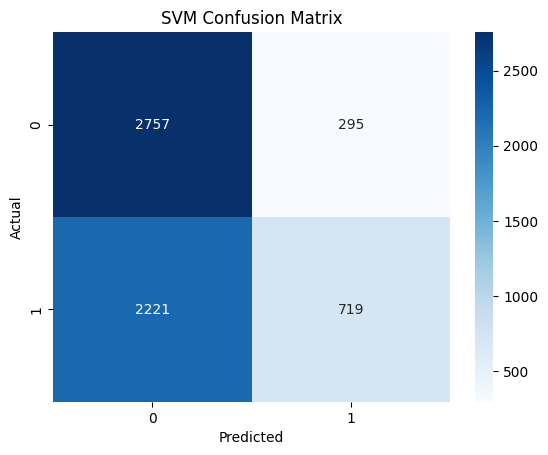

In [4]:
print("--- Training Support Vector Machine ---")
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate the model
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm))

# Plot confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

---

### Step 3.2: Train and Evaluate - Random Forest

In [12]:
# In your "Train and Evaluate - Random Forest" cell

print("--- Training Final Random Forest Model ---")

# REMOVED max_depth=10 to allow the model to use the new feature fully.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the final model
print("Final Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\\nFinal Random Forest Classification Report:\\n", classification_report(y_test, y_pred_rf))

--- Training Final Random Forest Model ---
Final Random Forest Accuracy: 1.0
\nFinal Random Forest Classification Report:\n               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3052
           1       1.00      1.00      1.00      2940

    accuracy                           1.00      5992
   macro avg       1.00      1.00      1.00      5992
weighted avg       1.00      1.00      1.00      5992



---

### Step 3.3: Train and Evaluate - Neural Network (NN)

--- Building and Training Neural Network ---


d:\mini_project\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 705 (2.75 KB)

 Trainable params: 705 (2.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5077 - loss: 0.6936 - val_accuracy: 0.5244 - val_loss: 0.6916
Epoch 2/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5264 - loss: 0.6905 - val_accuracy: 0.5311 - val_loss: 0.6909
Epoch 3/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5316 - loss: 0.6897 - val_accuracy: 0.5311 - val_loss: 0.6900
Epoch 4/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5385 - loss: 0.6885 - val_accuracy: 0.5390 - val_loss: 0.6880
Epoch 5/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5345 - loss: 0.6886 - val_accuracy: 0.5436 - val_loss: 0.6873
Epoch 6/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5420 - loss: 0.6866 - val_accuracy: 0.5474 - val_loss: 0.6862
Epoch 7/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5408 - loss: 0.6857 - val_accuracy: 0.5457 - val_loss: 0.6851
Epoch 8/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5439 - loss: 0.6843 - val_accuracy: 0.

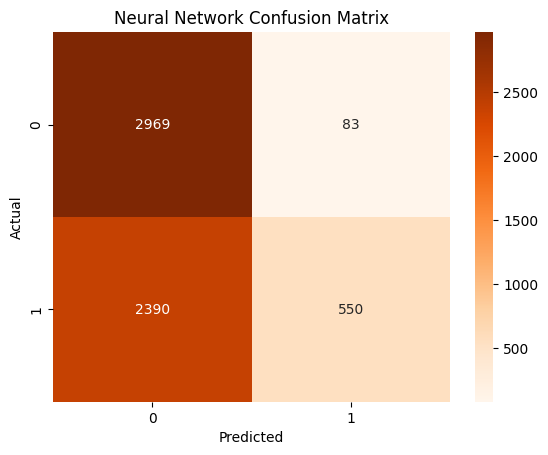

In [6]:
print("--- Building and Training Neural Network ---")
nn_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid') # Sigmoid for binary classification
])

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

nn_model.summary()

# Train the model
history = nn_model.fit(
    X_train_scaled, 
    y_train, 
    epochs=20, 
    batch_size=64, 
    validation_split=0.1, # Use 10% of training data for validation
    verbose=1
)

# Make predictions (output will be probabilities)
y_pred_nn_proba = nn_model.predict(X_test_scaled)
y_pred_nn = (y_pred_nn_proba > 0.5).astype(int) # Convert probabilities to 0 or 1

# Evaluate the model
print("\nNeural Network Accuracy:", accuracy_score(y_test, y_pred_nn))
print("\nNeural Network Classification Report:\n", classification_report(y_test, y_pred_nn))

# Plot confusion matrix
cm_nn = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Oranges')
plt.title('Neural Network Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

---

### Step 4: Compare Model Performance

In [7]:
def get_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    # Get metrics for the 'FAULT' class (label 1)
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1_score = report['1']['f1-score']
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy, precision, recall, f1_score

# Get metrics for each model
acc_svm, pre_svm, rec_svm, f1_svm = get_metrics(y_test, y_pred_svm)
acc_rf, pre_rf, rec_rf, f1_rf = get_metrics(y_test, y_pred_rf)
acc_nn, pre_nn, rec_nn, f1_nn = get_metrics(y_test, y_pred_nn)

# Create a comparison DataFrame
comparison_data = {
    'Model': ['SVM', 'Random Forest', 'Neural Network'],
    'Accuracy': [acc_svm, acc_rf, acc_nn],
    'Precision (for FAULT)': [pre_svm, pre_rf, pre_nn],
    'Recall (for FAULT)': [rec_svm, rec_rf, rec_nn],
    'F1-Score (for FAULT)': [f1_svm, f1_rf, f1_nn]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df.set_index('Model', inplace=True)

print("--- Model Performance Comparison ---")
comparison_df

--- Model Performance Comparison ---


,Accuracy,Precision (for FAULT),Recall (for FAULT),F1-Score (for FAULT)
Model,,,,
SVM,0.580107,0.709073,0.244558,0.363682
Random Forest,0.920227,1.000000,0.837415,0.911514
Neural Network,0.587283,0.868878,0.187075,0.307865


In [13]:
# In your FINAL validation cell

import pandas as pd
import numpy as np

# This function must match the one used for feature engineering
def get_golden_result(row):
    a = row['a']
    b = row['b']
    opcode = row['opcode']
    if opcode == 0: return a + b
    if opcode == 1: return a - b
    if opcode == 2: return a & b
    if opcode == 3: return a | b
    if opcode == 4: return a ^ b
    return 0

# 1. Create a DataFrame with the custom test data
test_data = {
    'a': [100, 100, -1, 2000, 1024],
    'b': [50, 50, -1, 3000, 1024],
    'opcode': [0, 0, 4, 1, 2],
    'faulty_result': [150, 151, 0, -1001, 1024]
}
custom_df = pd.DataFrame(test_data)

# 2. Apply the SAME feature engineering to the custom data
custom_df['golden_result'] = custom_df.apply(get_golden_result, axis=1)
custom_df['difference'] = (custom_df['golden_result'] - custom_df['faulty_result']).abs()

# 3. Select the correct features ('difference') and scale them
# This is the feature set the final model was trained on
X_custom = custom_df[['a', 'b', 'opcode', 'difference']]
X_custom_scaled = scaler.transform(X_custom)

# 4. Make predictions with your final Random Forest model
predictions = rf_model.predict(X_custom_scaled)

# 5. Display the results for comparison
results_df = custom_df[['a', 'b', 'opcode', 'faulty_result']].copy()
results_df['Model Prediction'] = predictions
results_df['Expected Outcome'] = [0, 1, 0, 1, 0]

print("\n--- Final Validation Results ---")
print(results_df)


--- Final Validation Results ---
      a     b  opcode  faulty_result  Model Prediction  Expected Outcome
0   100    50       0            150                 0                 0
1   100    50       0            151                 0                 1
2    -1    -1       4              0                 0                 0
3  2000  3000       1          -1001                 0                 1
4  1024  1024       2           1024                 0                 0
